### Elasticnet – Fold-Based Evaluation


* **Dataset:** Wind turbine power generation data, split into 8 temporal folds using a sliding window approach.
* **Per Fold Workflow:**
  * Select a random pool of **2000 samples** from the fold.
  * Use a defined **percentage of labeled samples** (e.g., 10%, 20%, 30%) for training.
  * Evaluate on the **remaining samples of the fold** (test set).
* **ElasticNet Model:**

  * Hyperparameters (`alpha`, `l1_ratio`) are optimized using `GridSearchCV`.
  * Data is preprocessed using `StandardScaler`.

This notebook enables a **fair comparison** of ElasticNet against semi-supervised methods (like S2RMS) by evaluating performance **under limited supervision**, using the **same folds, splits, and evaluation criteria**.

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.io import arff

sns.set_theme(style="whitegrid")


In [47]:
DATA_DIR = "../data/swdpf/arff_folds"
RESULTS_DIR = "../results/elasticnet_folds"
os.makedirs(RESULTS_DIR, exist_ok=True)

SCALES = [0.1, 0.2, 0.3]
FOLDS = range(8)
TARGET_COL = "patv_target_1"
SEED = 42


In [ ]:
def evaluate_elasticnet_on_fold(data, scale, fold):
    pool = data.sample(2000, random_state=fold)
    labeled = pool.sample(int(2000 * scale), random_state=fold)
    test = data.drop(pool.index)

    X_train = labeled.drop(columns=[TARGET_COL])
    y_train = labeled[TARGET_COL]

    X_test = test.drop(columns=[TARGET_COL])
    y_test = test[TARGET_COL]

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("elasticnet", ElasticNet(max_iter=10000))
    ])

    param_grid = {
        "elasticnet__alpha": [0.1, 1.0, 10.0],
        "elasticnet__l1_ratio": [0.1, 0.5, 0.9]
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    scaler_y_path = os.path.join(DATA_DIR, f"scaler_y_fold{fold}.joblib")
    scaler_y = joblib.load(scaler_y_path)

    y_test_denorm = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
    y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    rse = np.sum((y_test_denorm - y_pred_denorm) ** 2) / np.sum((y_test_denorm - np.mean(y_test_denorm)) ** 2)
    r2 = r2_score(y_test_denorm, y_pred_denorm)

    return {
        "fold": fold,
        "scale": scale,
        "rmse": rmse,
        "mae": mae,
        "rse": rse,
        "r2": r2,
        "best_params": grid_search.best_params_
    }

In [49]:
results = []

for fold in FOLDS:
    arff_path = os.path.join(DATA_DIR, f"fold{fold}.arff")
    data, _ = arff.loadarff(arff_path)
    df = pd.DataFrame(data)

    for scale in SCALES:
        print(f"Fold {fold} | Scale {scale}")
        metrics = evaluate_elasticnet_on_fold(df, scale, fold)
        results.append(metrics)


Fold 0 | Scale 0.1
Fold 0 | Scale 0.2
Fold 0 | Scale 0.3
Fold 1 | Scale 0.1
Fold 1 | Scale 0.2
Fold 1 | Scale 0.3
Fold 2 | Scale 0.1
Fold 2 | Scale 0.2
Fold 2 | Scale 0.3
Fold 3 | Scale 0.1
Fold 3 | Scale 0.2
Fold 3 | Scale 0.3
Fold 4 | Scale 0.1
Fold 4 | Scale 0.2
Fold 4 | Scale 0.3
Fold 5 | Scale 0.1
Fold 5 | Scale 0.2
Fold 5 | Scale 0.3
Fold 6 | Scale 0.1
Fold 6 | Scale 0.2
Fold 6 | Scale 0.3
Fold 7 | Scale 0.1
Fold 7 | Scale 0.2
Fold 7 | Scale 0.3


### **Evaluation Metrics**

Each model is evaluated using the following metrics:

| Metric                                | Description                                                  |
| ------------------------------------- | ------------------------------------------------------------ |
| **RMSE** (Root Mean Squared Error)    | Measures prediction error magnitude (sensitive to outliers). |
| **MAE** (Mean Absolute Error)         | Measures average absolute prediction error.                  |
| **RSE** (Relative Squared Error)      | Ratio of model error to the variance of the target.          |
| **R²** (Coefficient of Determination) | Measures the proportion of variance explained by the model.  |

In [50]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(RESULTS_DIR, "elasticnet_fold_results.csv"), index=False)

print("Saved to:", os.path.join(RESULTS_DIR, "elasticnet_fold_results.csv"))
display(results_df)


Saved to: ../results/elasticnet_folds\elasticnet_fold_results.csv


,fold,scale,rmse,mae,rse,r2,best_params
0,0,0.1,137.356748,89.351173,0.115149,0.884851,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
1,0,0.2,136.854532,87.208705,0.114308,0.885692,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
2,0,0.3,137.816756,86.834033,0.115921,0.884079,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
3,1,0.1,122.221381,80.785181,0.088710,0.911290,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
4,1,0.2,116.177516,74.180698,0.080154,0.919846,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
5,1,0.3,115.950511,72.267296,0.079841,0.920159,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
6,2,0.1,88.782154,53.951377,0.053502,0.946498,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
7,2,0.2,85.755343,52.161796,0.049916,0.950084,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
8,2,0.3,83.774146,50.390802,0.047636,0.952364,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."
9,3,0.1,92.670996,58.803748,0.042952,0.957048,"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."


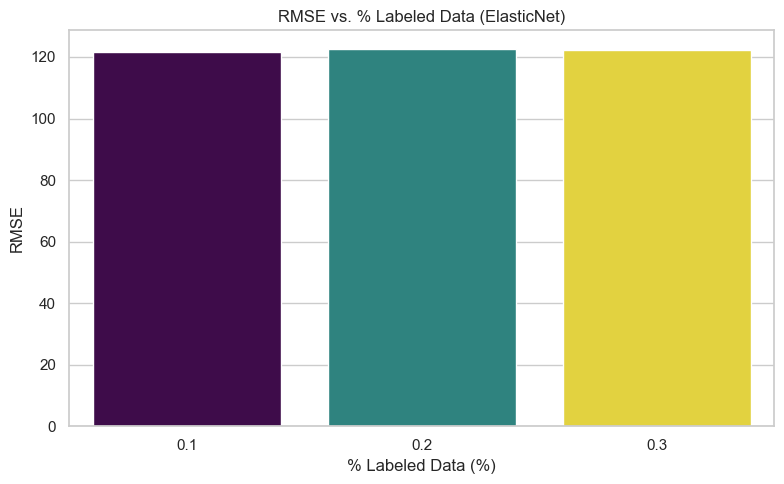

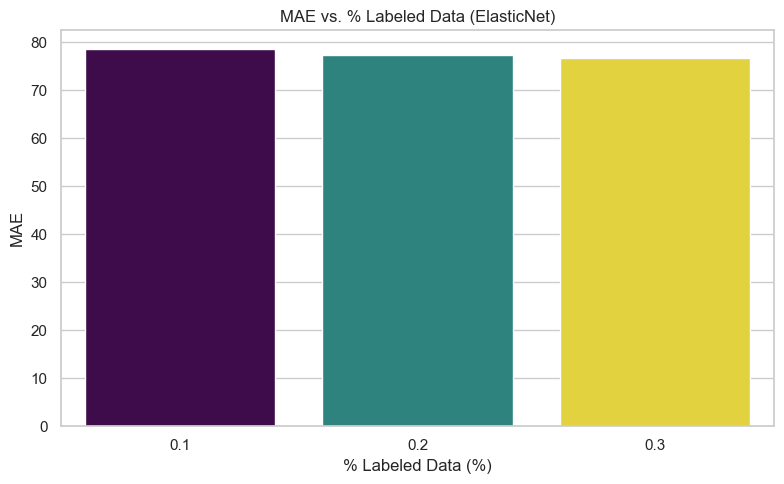

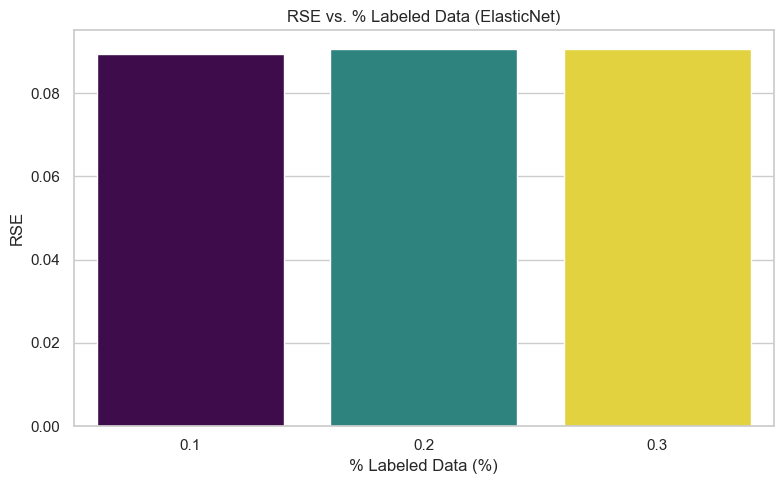

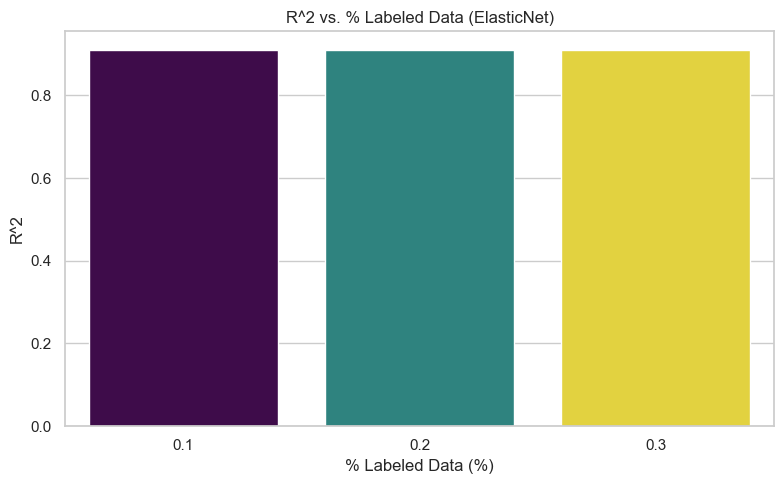

In [51]:
summary_df = results_df.groupby("scale").agg(
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    mae_mean=("mae", "mean"),
    mae_std=("mae", "std"),
    rse_mean=("rse", "mean"),
    rse_std=("rse", "std"),
    r2_mean=("r2", "mean"),
    r2_std=("r2", "std")
).reset_index()

def plot_metric(df, metric, ylabel):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x="scale",
        y=f"{metric}_mean",
        hue="scale",
        data=df,
        palette="viridis",
        legend=False
    )
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs. % Labeled Data (ElasticNet)")
    plt.xlabel("% Labeled Data (%)")
    plt.tight_layout()
    plt.show()

plot_metric(summary_df, "rmse", "RMSE")
plot_metric(summary_df, "mae", "MAE")
plot_metric(summary_df, "rse", "RSE")
plot_metric(summary_df, "r2", "R^2")